In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/TFG/notebooks/')

In [3]:
from functions import *

Dependencies installed successfully.


In [4]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

In [51]:
lst = '/content/gdrive/MyDrive/TFG/data/preprocessed/lst'
wt = '/content/gdrive/MyDrive/TFG/data/preprocessed/wt'
wt_interpolated = '/content/gdrive/MyDrive/TFG/data/preprocessed/wt_interpolated'
masked = '/content/gdrive/MyDrive/TFG/data/preprocessed/lst/masked'
ndvi = '/content/gdrive/MyDrive/TFG/data/preprocessed/ndvi'

In [52]:
W = 64

dir_paths = [lst,wt_interpolated,masked,ndvi]
data, time_slots = load_data(dir_paths,W,[True,False,True,False])
data_inputs = data[dir_paths[0]]
data_targets = data[dir_paths[1]]
masked_inputs = data[dir_paths[2]]
ndvi = data[dir_paths[3]]

print('inputs shape:', data_inputs.shape,masked_inputs.shape)
print('targets shape:', data_targets.shape)

inputs shape: (34, 64, 64, 3) (34, 64, 64, 3)
targets shape: (34, 64, 64)


In [ ]:
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  img_rgb = masked_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)

(35, 64, 64)


In [24]:
lst = pd.read_csv(f'{lst}/leboiron_lst.csv',index_col=0)

,29,30,31,32,285,286,287,288,541,542,...,65207,65208,65209,65210,65461,65462,65463,65464,65465,65466
2013-06,44.908076,147.295560,1.181710e+02,48.733964,57.722422,143.451364,61.752930,0.001196,10.965808,150.137229,...,123.831116,23.025738,0.004513,0.004026,6.841812e-04,0.003486,31.504103,154.815837,188.962313,170.367884
2014-01,5.258128,16.870674,1.289863e+01,5.159278,6.312154,14.889073,6.233140,0.000117,1.059019,14.576432,...,26.019301,5.059771,0.001117,0.001167,1.555817e-04,0.000770,6.681184,34.082292,44.741005,46.071424
2014-09,74.244779,243.985153,1.976904e+02,81.261562,95.688379,237.293438,101.414348,0.001972,18.214841,249.732429,...,249.137014,45.192323,0.008348,0.006663,1.424872e-03,0.007102,63.777997,305.946233,357.168090,293.763953
2015-03,0.046515,0.000001,1.103007e-07,0.052682,0.454361,0.837865,0.039577,0.000001,0.106523,1.466190,...,0.000000,0.000000,0.000000,0.000000,2.352714e-12,0.000000,0.000000,0.000000,0.000000,0.000000
2016-07,23.676014,79.626724,6.514830e+01,26.972961,30.833835,77.745303,33.574409,0.000657,5.930505,81.628007,...,69.951017,12.892839,0.002502,0.002166,3.899003e-04,0.001965,17.636404,86.642802,103.931955,88.310065
2016-09,41.064461,134.975501,1.092237e+02,44.794382,52.486633,129.568276,55.757502,0.001092,9.906790,134.581449,...,115.778629,21.873299,0.004384,0.004062,6.364666e-04,0.003234,29.280693,145.940818,181.054811,168.542540
2016-10,2.444782,6.823473,5.582770e+00,1.873959,2.335568,5.553235,2.398173,0.000046,0.317706,4.372935,...,25.115579,4.796207,0.001020,0.001078,1.405114e-04,0.000721,6.435354,31.908634,42.476906,44.463675
2016-12,61.065876,203.799091,1.653247e+02,68.343042,79.757067,198.983726,85.522942,0.001666,15.249870,209.900584,...,198.805765,36.499262,0.007013,0.005809,1.123692e-03,0.005705,52.228221,259.367000,305.611150,251.698838
2017-01,57.321903,190.622021,1.546204e+02,63.579123,73.967412,184.645098,79.205257,0.001549,14.084950,193.866516,...,145.149277,27.299648,0.005442,0.005002,7.985839e-04,0.004071,37.144082,184.769455,227.554481,208.935606
2017-03,47.498184,158.775197,1.298285e+02,53.752123,61.448034,152.331663,65.587899,0.001277,11.600599,157.895190,...,68.917806,12.695657,0.002481,0.002234,3.983959e-04,0.002007,17.956521,87.822987,108.173366,96.633681


In [29]:
targets = pd.read_csv(f'{wt_interpolated}/leboiron_wt_interpolated.csv',index_col=0)

,29,30,31,32,285,286,287,288,541,542,...,65207,65208,65209,65210,65461,65462,65463,65464,65465,65466
2013-06,1.414473,4.757129,3.892146,1.611442,1.853023,4.644727,2.005831,0.000039,0.354305,4.876691,...,2.863825,0.546544,0.000112,0.000106,0.000015,0.000078,0.721051,3.636097,4.578319,4.330676
2014-01,2.033731,6.840923,5.597903,2.317839,2.664024,6.675876,2.882401,0.000056,0.508911,7.004927,...,4.408789,0.840692,0.000171,0.000162,0.000024,0.000121,1.109118,5.588513,7.029804,6.646837
2014-09,2.423843,8.153072,6.671722,2.762459,3.175070,7.956741,3.435530,0.000067,0.606583,8.349340,...,5.137964,0.979679,0.000200,0.000189,0.000027,0.000141,1.292482,6.512242,8.191516,7.745655
2015-03,2.870015,9.654258,7.900476,3.271294,3.759435,9.420562,4.067366,0.000080,0.718058,9.883817,...,6.145782,1.171358,0.000238,0.000225,0.000033,0.000169,1.545363,7.782999,9.784155,9.248206
2016-07,3.527772,11.867513,9.712176,4.021551,4.620881,11.578242,4.998616,0.000098,0.882328,12.145085,...,7.682086,1.463789,0.000298,0.000281,0.000041,0.000211,1.931164,9.723486,12.219835,11.548877
2016-09,3.528088,11.868192,9.712601,4.021668,4.621415,11.580498,4.999945,0.000098,0.882665,12.149616,...,7.578230,1.444294,0.000294,0.000278,0.000041,0.000208,1.905444,9.596202,12.063786,11.404129
2016-10,3.268236,10.993571,8.996536,3.725100,4.281154,10.728645,4.632438,0.000091,0.817887,11.257861,...,6.777393,1.291919,0.000263,0.000249,0.000036,0.000186,1.704418,8.585550,10.795178,10.205521
2016-12,3.049834,10.258296,8.394446,3.475718,3.995204,10.012935,4.323725,0.000085,0.763496,10.509081,...,6.017481,1.147634,0.000234,0.000221,0.000032,0.000165,1.514064,7.630790,9.601336,9.080986
2017-01,2.289552,7.700060,6.300336,2.608513,2.999474,7.518812,3.247225,0.000064,0.573594,7.894999,...,4.177974,0.797460,0.000163,0.000154,0.000022,0.000114,1.052082,5.306881,6.684179,6.325431
2017-03,1.472019,4.949793,4.049394,1.676433,1.928635,4.835807,2.088935,0.000041,0.369166,5.081052,...,2.481310,0.474188,0.000097,0.000092,0.000013,0.000068,0.625591,3.159298,3.984964,3.773507


## Linear regression

Filter by river areas and flatten the data

In [53]:
data_targets.shape

(34, 64, 64)

In [54]:
# Aplanar los datos
X = masked_inputs.reshape(masked_inputs.shape[0], -1)  # (12, 64*64*3)
y = data_targets.reshape(data_targets.shape[0], -1)  # (12, 64*64)

In [55]:
y.shape

(34, 4096)

(1360,) (1360,)


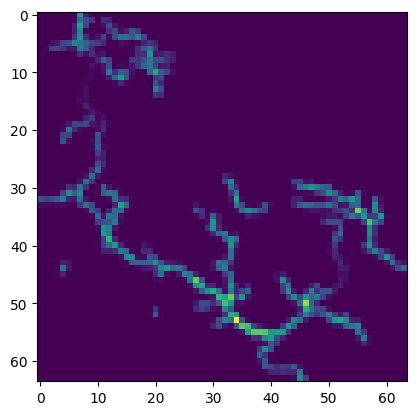

(1360,) (1360,)


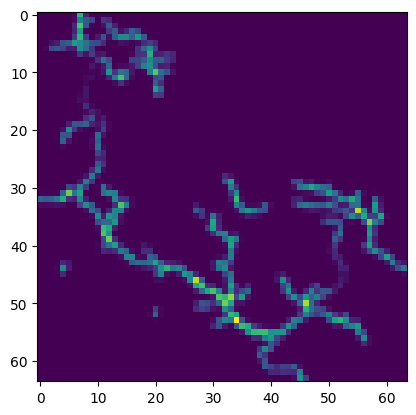

(1360,) (1360,)


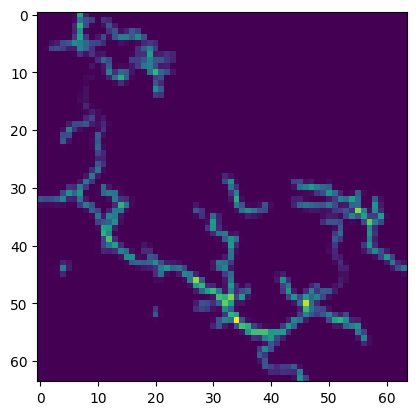

(1360,) (1360,)


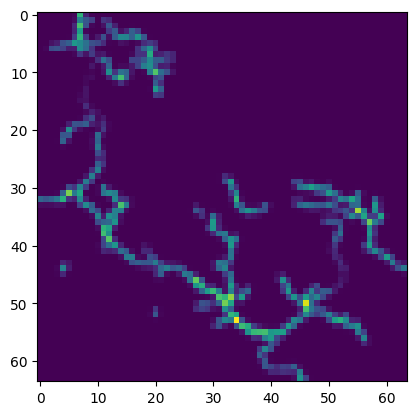

(1360,) (1360,)


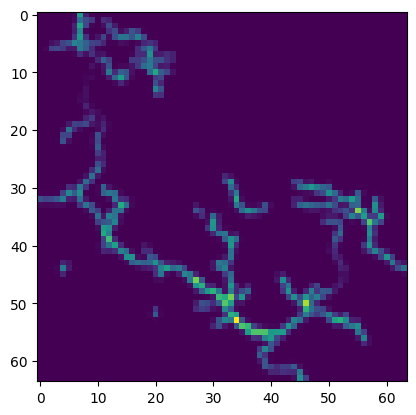

(1360,) (1360,)


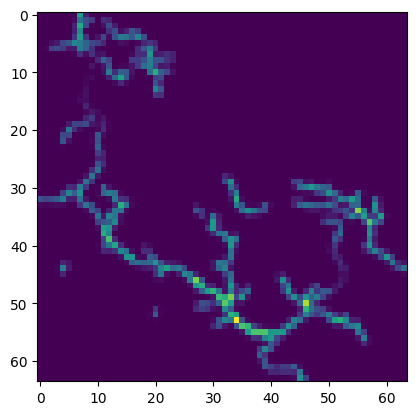

(1360,) (1360,)


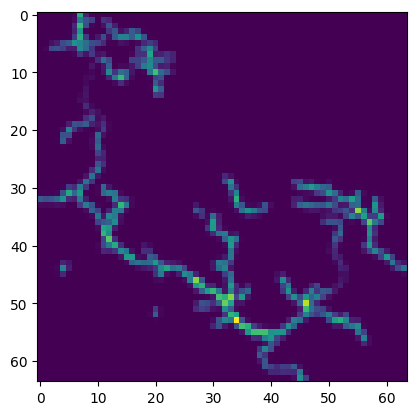

(1360,) (1360,)


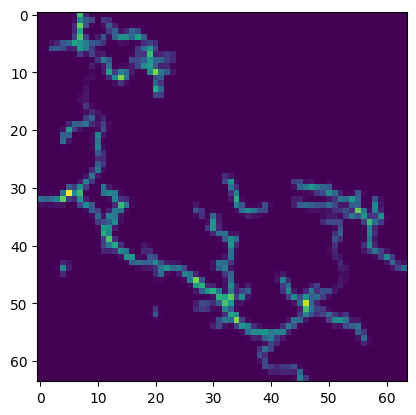

(1360,) (1360,)


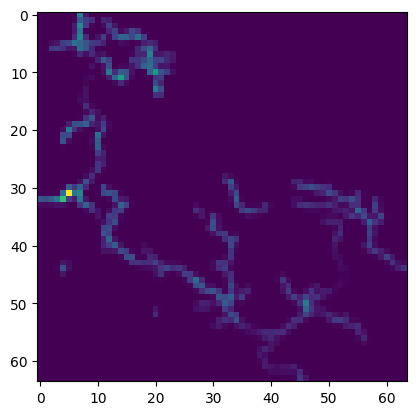

(1360,) (1360,)


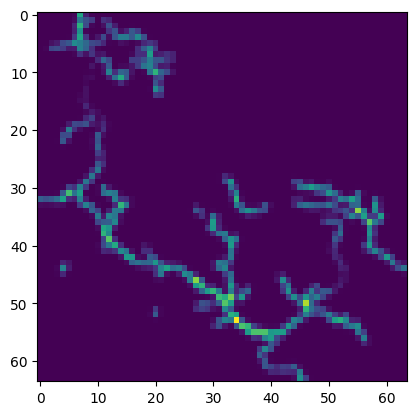

(1360,) (1360,)


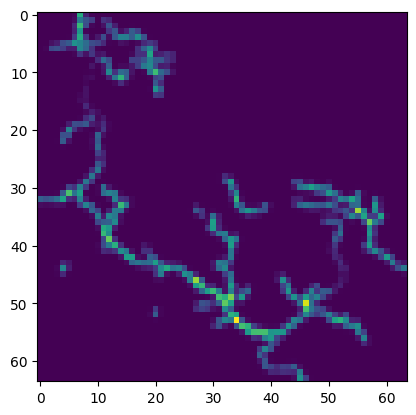

(1360,) (1360,)


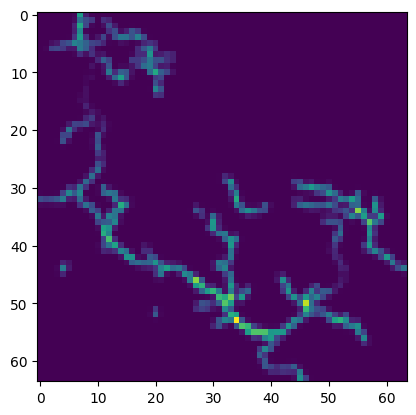

(1360,) (1360,)


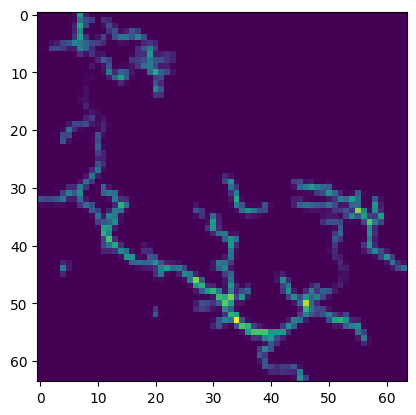

(1360,) (1360,)


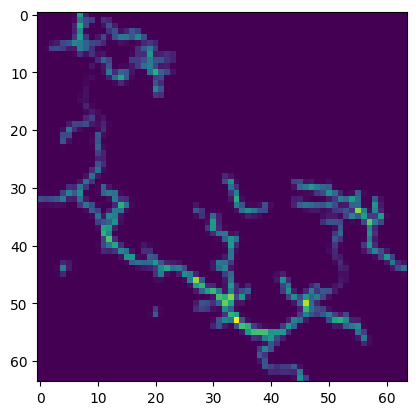

(1360,) (1360,)


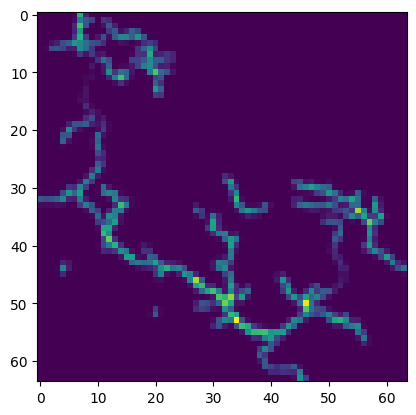

(1360,) (1360,)


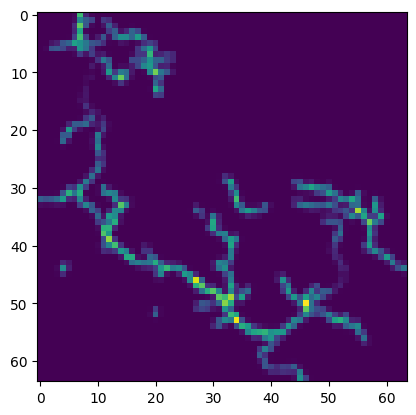

(1360,) (1360,)


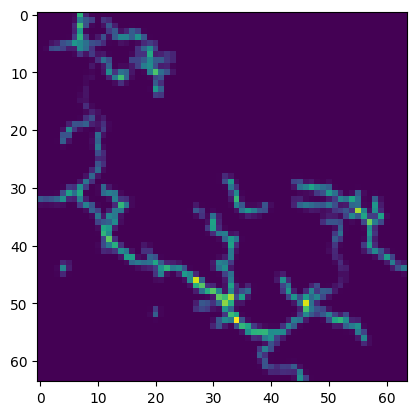

(1360,) (1360,)


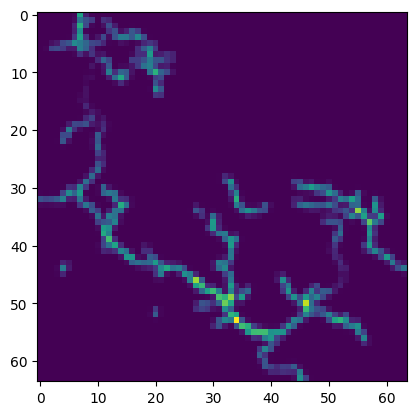

(1360,) (1360,)


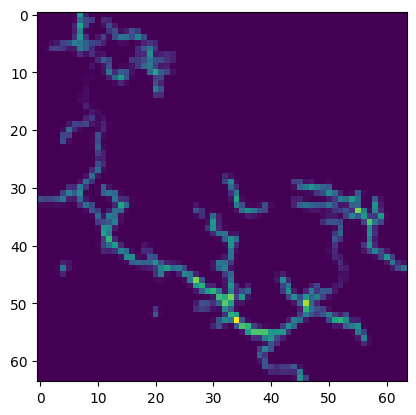

(1360,) (1360,)


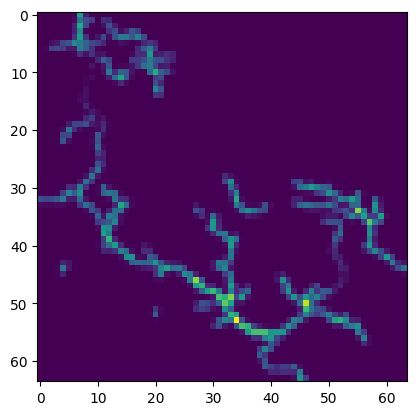

(1360,) (1360,)


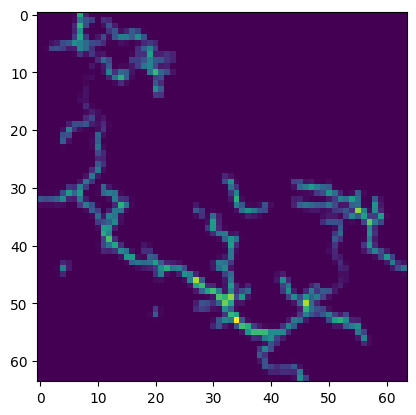

(1360,) (1360,)


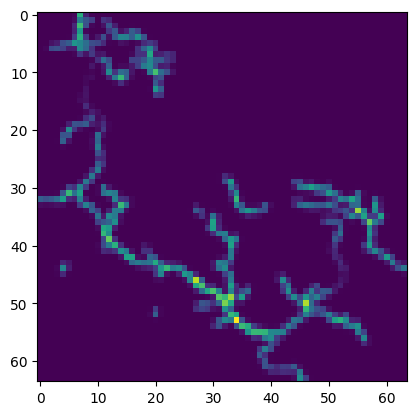

(1360,) (1360,)


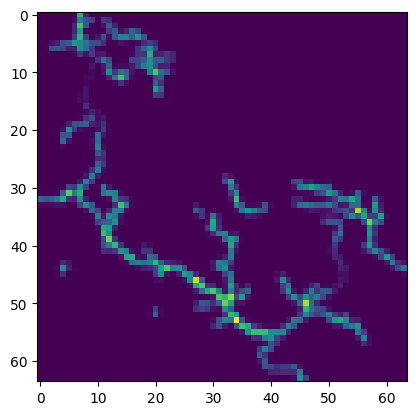

(1360,) (1360,)


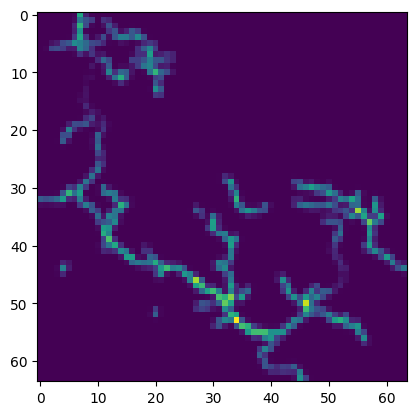

(1360,) (1360,)


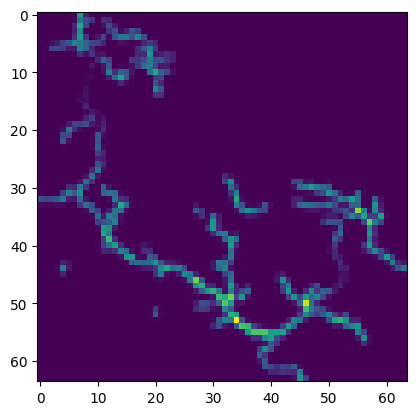

(1360,) (1360,)


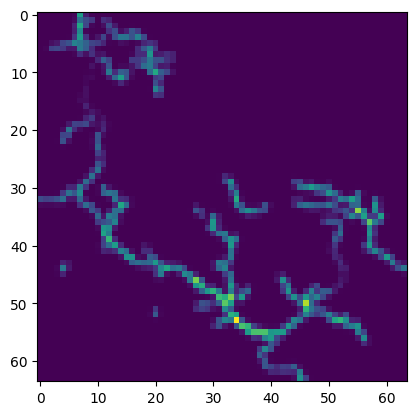

(1360,) (1360,)


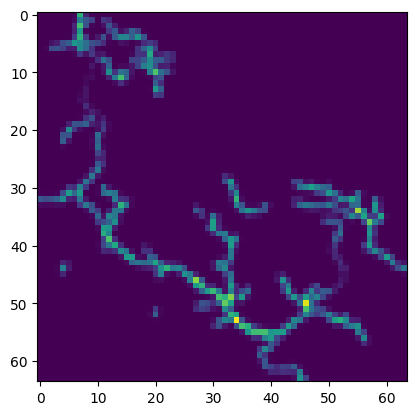

(1360,) (1360,)


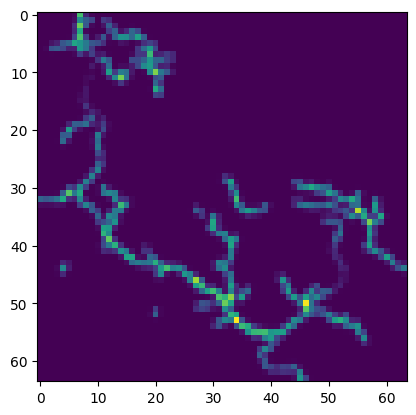

(1360,) (1360,)


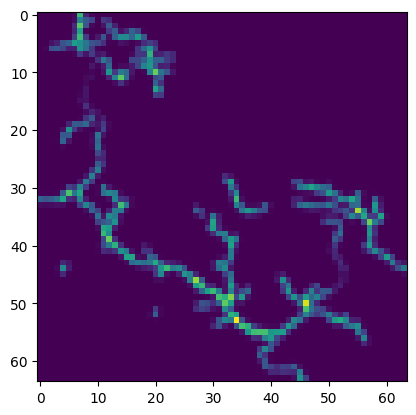

(1360,) (1360,)


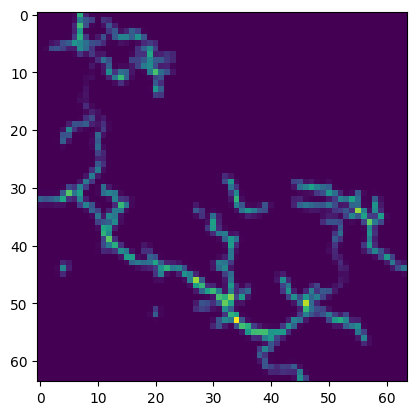

(1360,) (1360,)


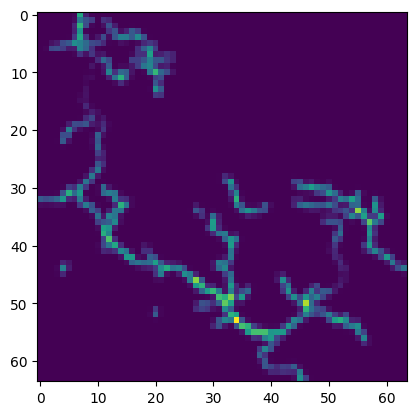

(1360,) (1360,)


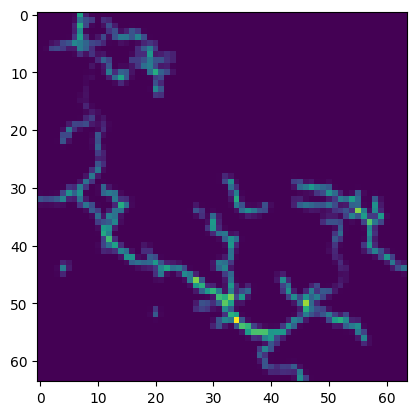

(1360,) (1360,)


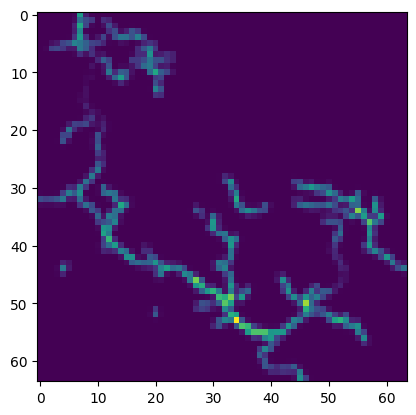

(1360,) (1360,)


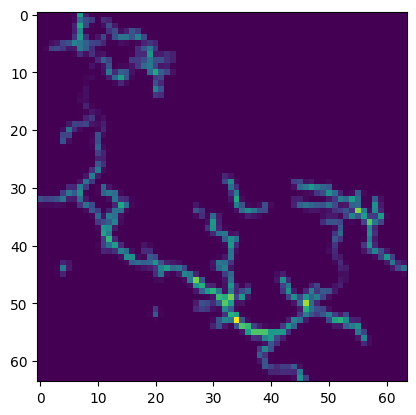

inputs shape: (34, 1360)
outputs shape: (34, 1360)


In [56]:
filtered_inputs = []
filtered_outputs = []
del_indices = []
for i in range(masked_inputs.shape[0]):
  img_rgb = masked_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution

  img_gray = img_gray.flatten()
  img_gray = img_gray[y[i]!=0] # flattening and filtering the image
  y_filt = y[i][y[i]!=0]

  print(img_gray.shape,y_filt.shape)
  if img_gray.shape[0]!=4215:
    plt.imshow(data_targets[i])
    plt.show()
  if img_gray.shape == y_filt.shape and not img_gray.shape[0]==0: # only add the image if it contains temperature data for all the river
    filtered_inputs.append(img_gray)
    filtered_outputs.append(y_filt)
  else:
    del_indices.append(i)

    #print('pel mes',i)


filt_inputs = np.array(filtered_inputs)
filt_outputs = np.array(filtered_outputs)
print('inputs shape:',filt_inputs.shape)
print('outputs shape:',filt_outputs.shape)

#time_slots = np.delete(time_slots,i)

Show distribution differences

In [ ]:
import seaborn as sns
from scipy.stats import ks_2samp
p_values = {}
for i in range(filt_outputs.shape[0]):
  # Example temperature arrays
  temperature_array1 = filt_inputs[i]
  temperature_array2 = filt_outputs[i]

  # Plot KDE for both temperature arrays
  plt.figure(figsize=(10, 6))
  sns.kdeplot(temperature_array1, label='Landsat', fill=True)
  sns.kdeplot(temperature_array2, label='Water', fill=True)

  # Customize the plot
  plt.title('Temperature Distribution Comparison (KDE)')
  plt.xlabel('Temperature')
  plt.ylabel('Density')
  plt.legend(loc='upper right')
  plt.show()

  stat, p_value = ks_2samp(temperature_array1, temperature_array2)
  mse = mean_squared_error(temperature_array1, temperature_array2)
  rmse = np.sqrt(mse)


  p_values[i] = [p_value,rmse]


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pd.DataFrame(p_values,index=['ks p_value', 'RMSE'])

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
ks p_value,0.082425,0.538553,0.297009,0.143341,0.049911,0.119905,0.218181,0.131197,0.099708,0.119905,...,0.061271,0.018444,0.044948,0.082425,0.061271,0.044948,0.026044,0.218181,0.420954,0.666111
RMSE,0.098241,0.112346,0.239668,0.429996,0.565461,0.518187,0.483567,0.587630,0.533660,0.336129,...,0.252514,0.375876,0.397720,0.566296,0.669781,0.624072,0.553521,0.340460,0.191678,0.146695


Split train, validation and test sets

In [57]:
train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(filt_inputs, filt_outputs)
#train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(lst, targets)
#train_input, test_input, train_target, test_target = train_test_split(lst, targets, test_size=0.2, random_state=42)

Train the linear regression model

In [58]:
# Initialize the model
model = LinearRegression()

# Train the model using the training data
model.fit(train_input, train_target)


LinearRegression()

In [ ]:
y_pred = model.predict(test_input)


In [48]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Suponiendo que y_true y y_pred tienen la forma (7, 4052)
mses_por_muestra = [mean_squared_error(test_target.iloc[i], y_pred[i]) for i in range(test_target.shape[0])]

# Mostrar el MSE por muestra
for i, mse in enumerate(mses_por_muestra):
    print(f"MSE para la muestra {i}: {mse}")



MSE para la muestra 0: 1.776226610110664
MSE para la muestra 1: 14.88070794732568
MSE para la muestra 2: 5.571398605235327
MSE para la muestra 3: 0.3358262397584686
MSE para la muestra 4: 106.205824354394
MSE para la muestra 5: 1.300809518085062
MSE para la muestra 6: 8.08096619294799


In [64]:
validation_target.shape

(3, 1360)

In [61]:
# 6. Evaluar el rendimiento del modelo
mse = mean_squared_error(validation_target, validation_prediction)  # Error cuadrático medio
r2 = r2_score(test_target, y_pred)  # Coeficiente de determinación R^2

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R^2): {r2}")


ValueError: Found input variables with inconsistent numbers of samples: [3, 7]

In [37]:

# 6. Evaluar el rendimiento del modelo
mse = mean_squared_error(test_target, y_pred)  # Error cuadrático medio
r2 = r2_score(test_target, y_pred)  # Coeficiente de determinación R^2

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R^2): {r2}")

# Mostrar los coeficientes de la regresión lineal
print(f"Coeficientes de la regresión: {model.coef_}")
print(f"Intersección (bias): {model.intercept_}")

Error cuadrático medio (MSE): 19.735965638265313
Coeficiente de determinación (R^2): -9.7167823212103
Coeficientes de la regresión: [[-1.66671520e-04 -6.14839229e-04 -1.98697377e-04 ...  1.96827737e-04
   1.60237572e-04 -1.57999667e-04]
 [-5.60682124e-04 -2.06851066e-03 -6.68473703e-04 ...  6.62930409e-04
   5.40047878e-04 -5.30415850e-04]
 [-4.58890840e-04 -1.69311524e-03 -5.47179549e-04 ...  5.43017536e-04
   4.42590779e-04 -4.33392946e-04]
 ...
 [-4.40723776e-04 -1.70311380e-03 -5.83490895e-04 ...  8.46804367e-04
   8.62011365e-04  8.78902164e-05]
 [-5.53609627e-04 -2.13971212e-03 -7.33170968e-04 ...  1.06365227e-03
   1.08191630e-03  1.07280602e-04]
 [-5.23201961e-04 -2.02243993e-03 -6.93119761e-04 ...  1.00522479e-03
   1.02192287e-03  9.92780989e-05]]
Intersección (bias): [ 3.58434214 12.05798548  9.86818096 ...  9.91138812 12.46476553
 11.78652803]


In [62]:
print(f"Coeficientes de la regresión: {model.coef_}")
print(f"Intersección (bias): {model.intercept_}")

Coeficientes de la regresión: [[-2.07363158e-07  1.40333695e-07 -4.13721005e-07 ... -2.43375475e-07
  -1.72685509e-07 -5.16796199e-09]
 [-1.20737092e-01  8.26454784e-02 -2.00865429e-01 ... -1.24218137e-01
  -8.50571750e-02 -2.54646957e-03]
 [-3.60135255e+00  2.44707913e+00 -6.76744872e+00 ... -4.05621727e+00
  -2.85144452e+00 -8.53787062e-02]
 ...
 [-3.60135252e+00  2.47047017e+00 -5.83241832e+00 ... -4.41321332e+00
  -3.25629106e+00 -1.04239114e-01]
 [-1.45977153e+00  1.00681842e+00 -2.12928377e+00 ... -1.66544247e+00
  -1.20350716e+00 -3.85097966e-02]
 [-4.30228323e-02  2.97903603e-02 -5.76816007e-02 ... -4.62934287e-02
  -3.28718291e-02 -1.05182969e-03]]
Intersección (bias): [2.40935944e-07 1.17548188e-01 3.93588902e+00 ... 3.23937741e+00
 1.19886365e+00 3.27483765e-02]


In [63]:
len(model.coef_)

1360

#### Validate and test

In [59]:
validation_prediction = model.predict(validation_input)
#test_prediction = model.predict(test_input_flatten)

Metrics

In [60]:
results = evaluate_model(validation_target, validation_prediction)
for k,v in results.items():
  print(k,':',v)

MAE : 0.8492322057219998
MSE : 12.506448529434062
RMSE : 2.1342395228088487
R² : -36.7397976803202
MAPE (%) : 171.74790304384362
MSE sample-wise : 4.554978340719342


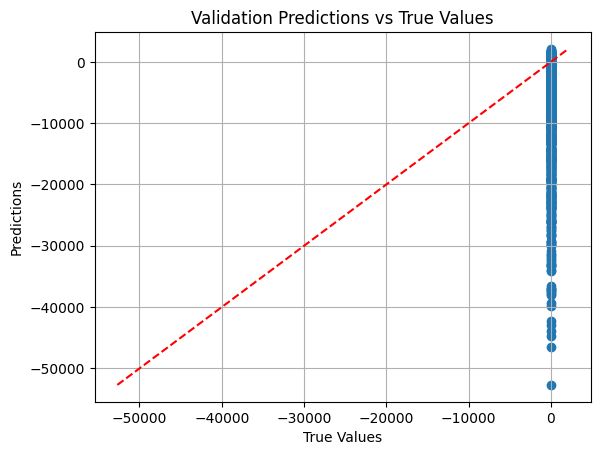

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(validation_target, validation_prediction)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Validation Predictions vs True Values')

min_val = min(validation_target.min(), validation_prediction.min())
max_val = max(validation_target.max(), validation_prediction.max())

# Dibuja la línea de referencia
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')  # Línea diagonal en rojo

plt.grid()
plt.show()


### Save model results

In [ ]:
model_name = "LR"
details = "RGB masked filtered air inputs, val results"
file_path = "/content/gdrive/MyDrive/TFG/results/model_results.xlsx"


# Update Excel with new results
update_excel_with_results(file_path, model_name, results['MSE'], results['MAE'], details)

## Physics regression

In [ ]:
W = 64
dir_paths = ['/content/gdrive/MyDrive/TFG/data/external/air temperature interpolated','/content/gdrive/MyDrive/TFG/data/raw/wt']
data = load_data(dir_paths,W,[False,False])
air_data = data[dir_paths[0]]
targets_data = data[dir_paths[1]]

In [ ]:
print(air_data.shape)
print(targets_data.shape)

(108, 64, 64)
(108, 64, 64)


(4096,)
(1366,) (1366,)
0


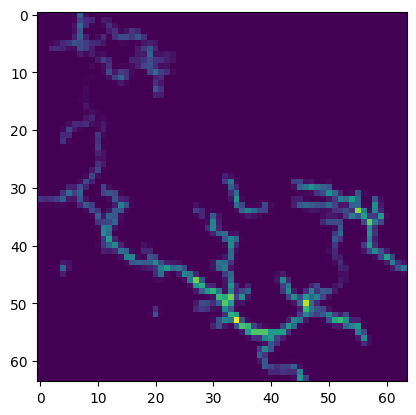

(4096,)
(1366,) (1366,)
1


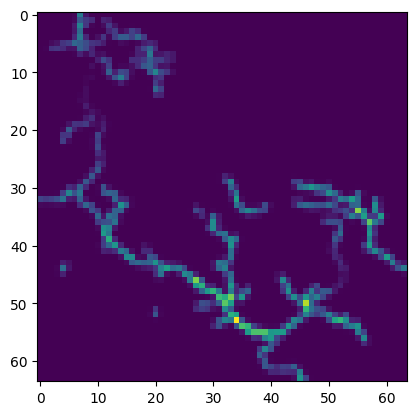

(4096,)
(1366,) (1366,)
2


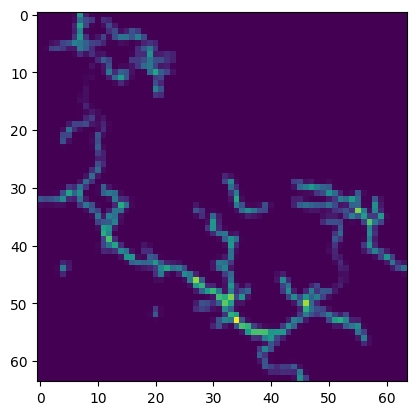

(4096,)
(1366,) (1366,)
3


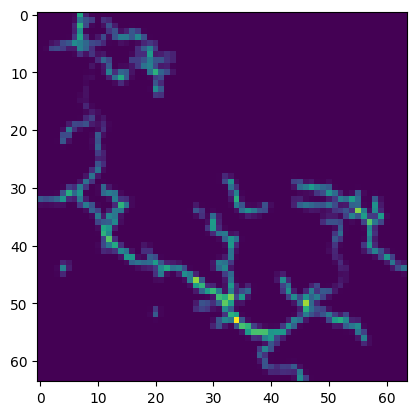

(4096,)
(1366,) (1366,)
4


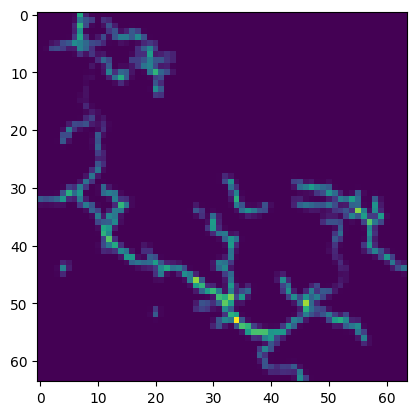

(4096,)
(1366,) (1366,)
5


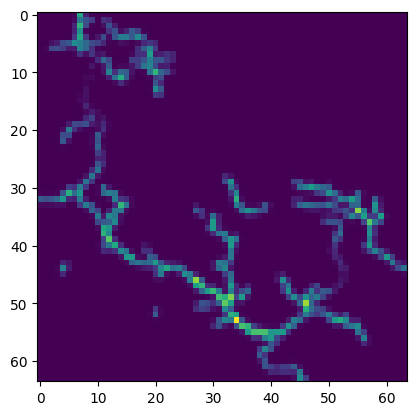

(4096,)
(1366,) (1366,)
6


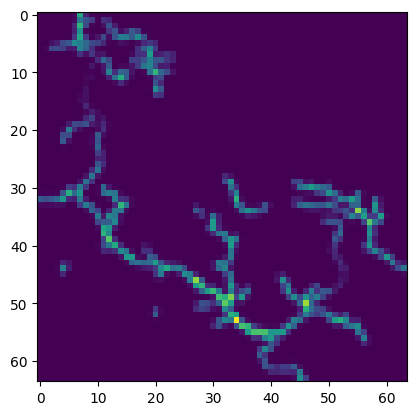

(4096,)
(1366,) (1366,)
7


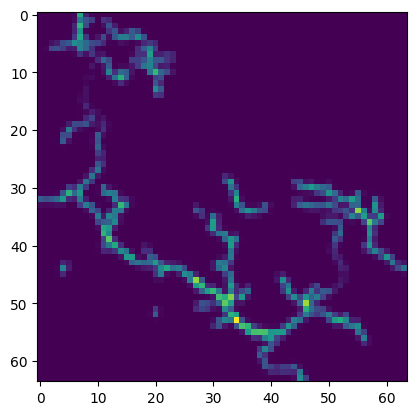

(4096,)
(1366,) (1366,)
8


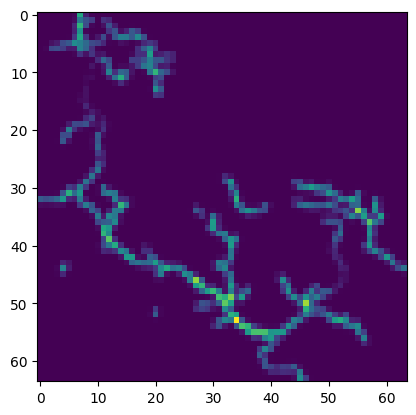

(4096,)
(1366,) (1366,)
9


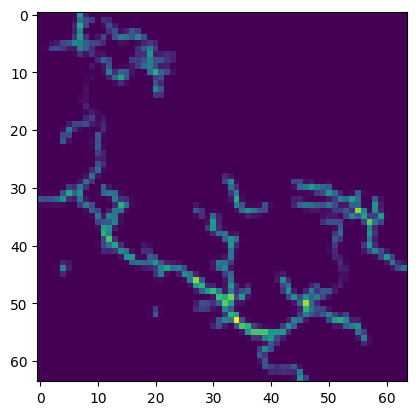

(4096,)
(1366,) (1366,)
10


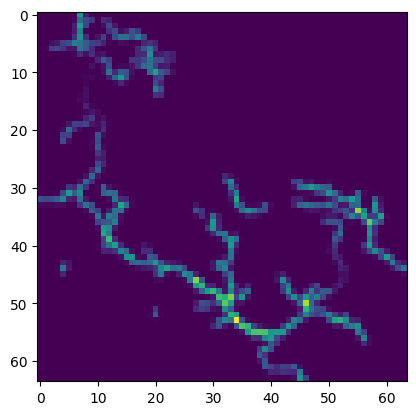

(4096,)
(1366,) (1366,)
11


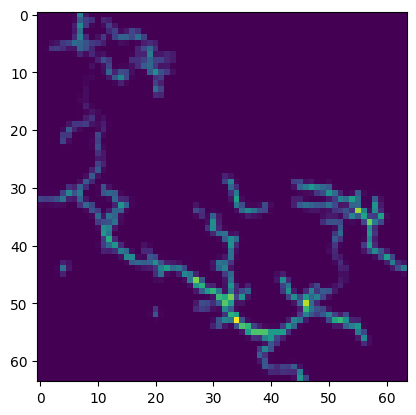

(4096,)
(1366,) (1366,)
12


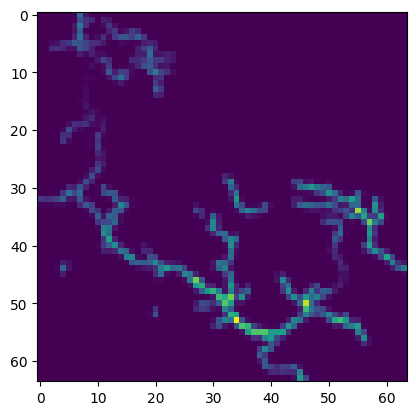

(4096,)
(1366,) (1366,)
13


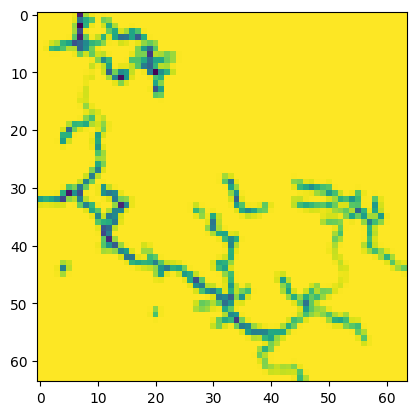

(4096,)
(1366,) (1366,)
14


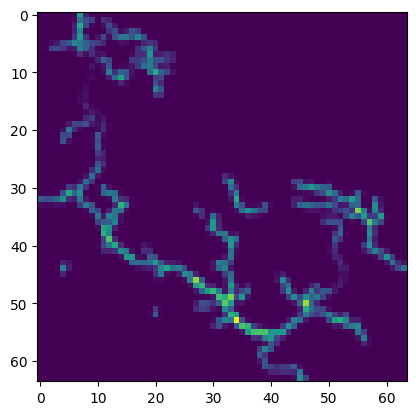

(4096,)
(1366,) (1366,)
15


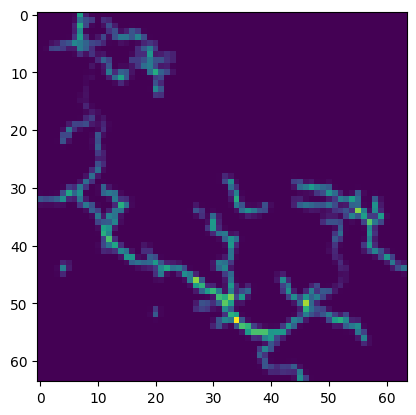

(4096,)
(1366,) (1366,)
16


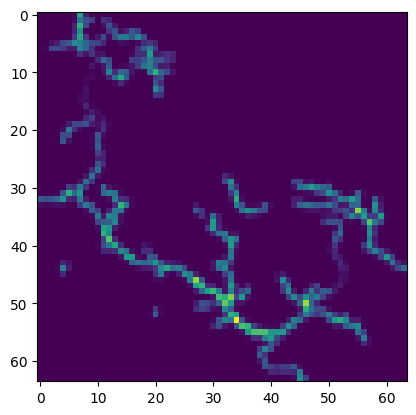

(4096,)
(1366,) (1366,)
17


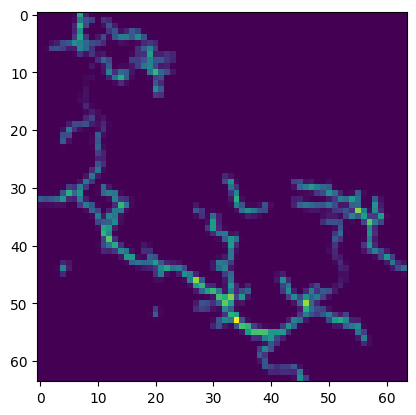

(4096,)
(1366,) (1366,)
18


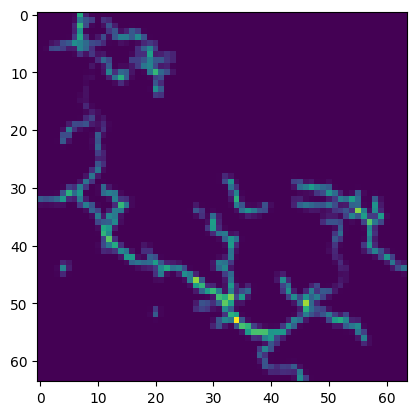

(4096,)
(1366,) (1366,)
19


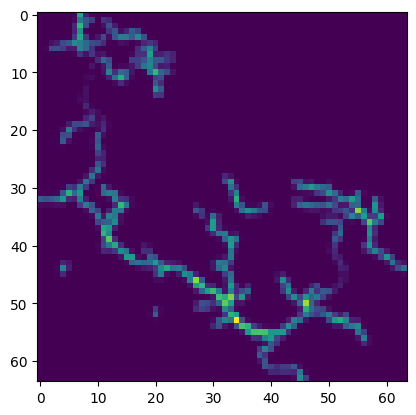

(4096,)
(1366,) (1366,)
20


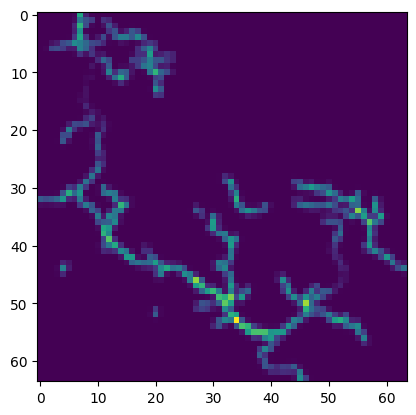

(4096,)
(1366,) (1366,)
21


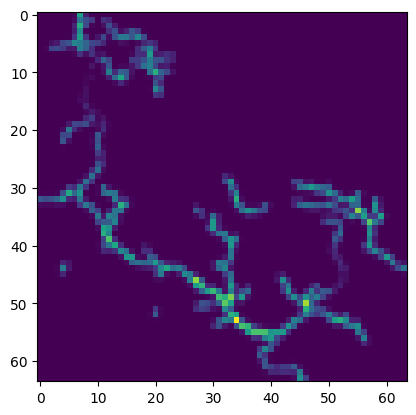

(4096,)
(1366,) (1366,)
22


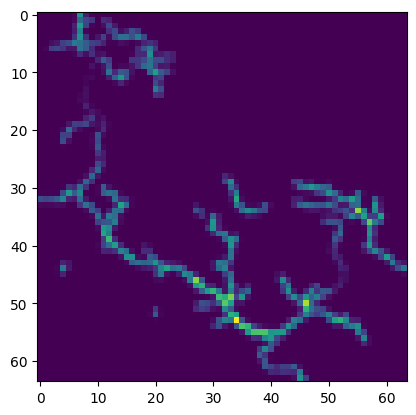

(4096,)
(1366,) (1366,)
23


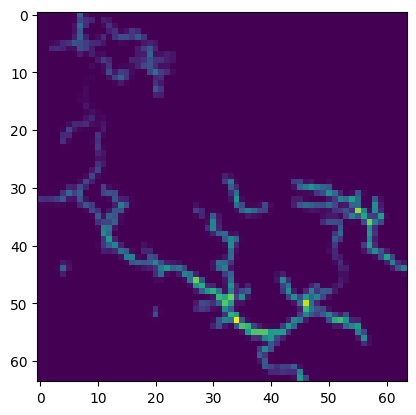

(4096,)
(1366,) (1366,)
24


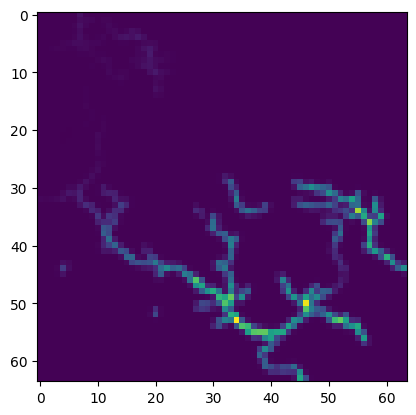

(4096,)
(1366,) (1366,)
25


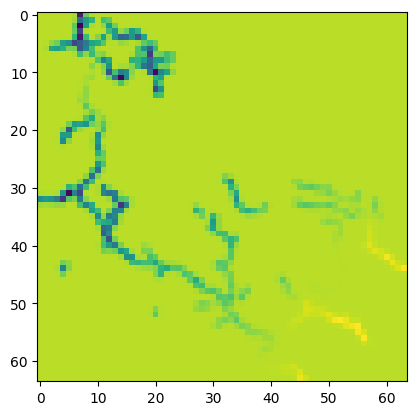

(4096,)
(1366,) (1366,)
26


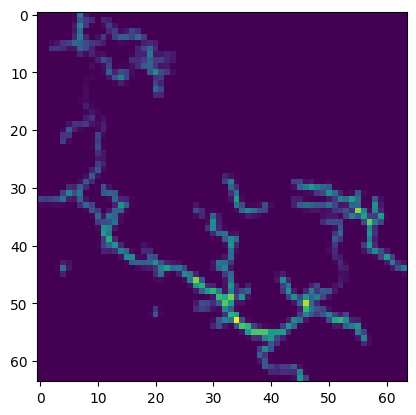

(4096,)
(1366,) (1366,)
27


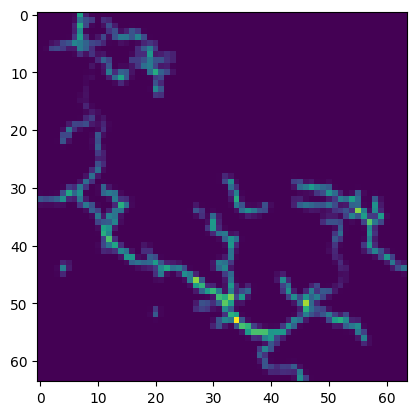

(4096,)
(1366,) (1366,)
28


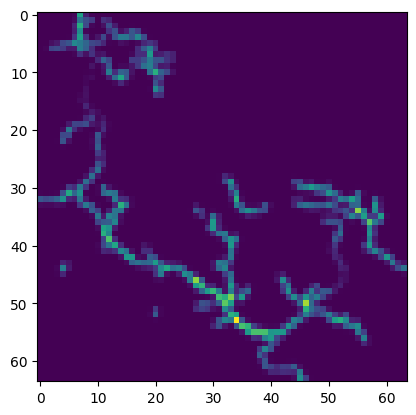

(4096,)
(1366,) (1366,)
29


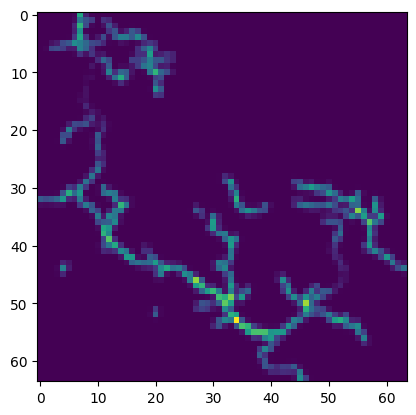

(4096,)
(1366,) (1366,)
30


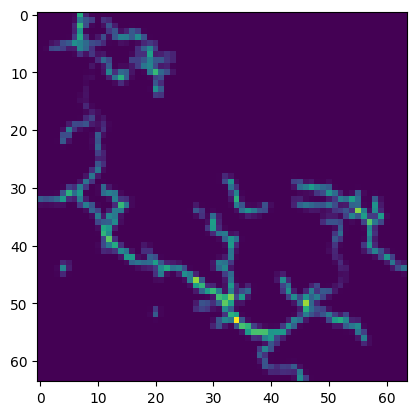

(4096,)
(1366,) (1366,)
31


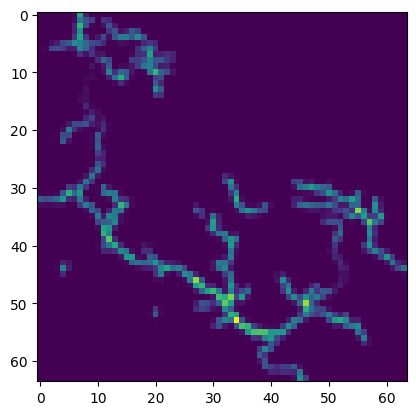

(4096,)
(1366,) (1366,)
32


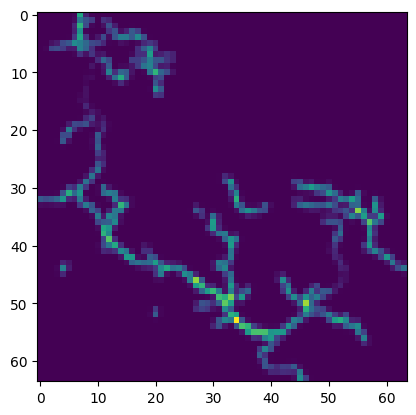

(4096,)
(1366,) (1366,)
33


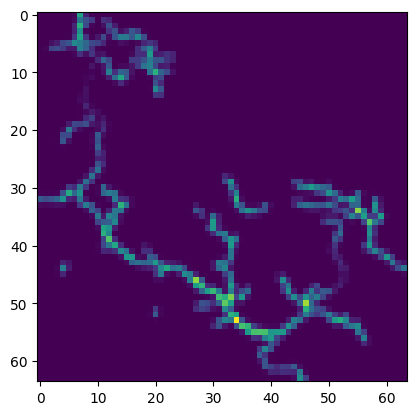

(4096,)
(1366,) (1366,)
34


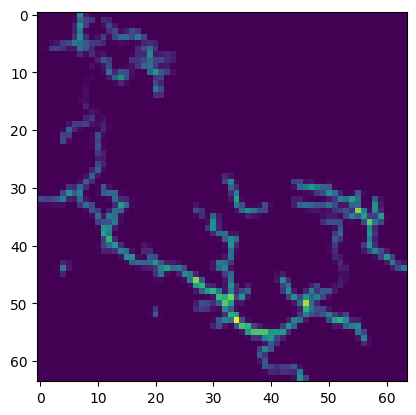

(4096,)
(1366,) (1366,)
35


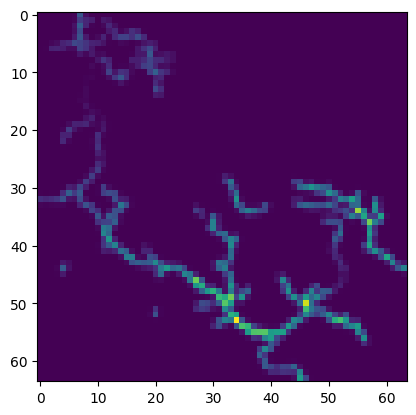

(4096,)
(1366,) (1366,)
36


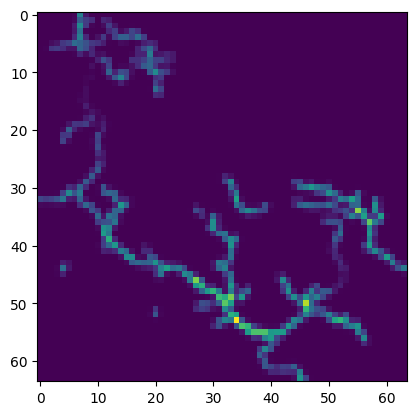

(4096,)
(1366,) (1366,)
37


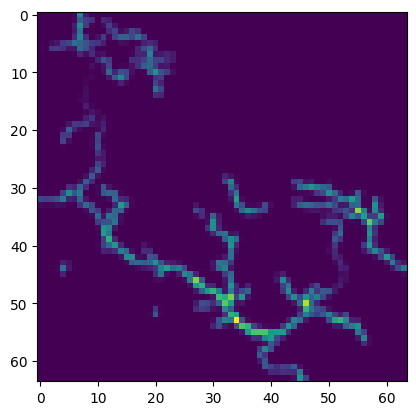

(4096,)
(1366,) (1366,)
38


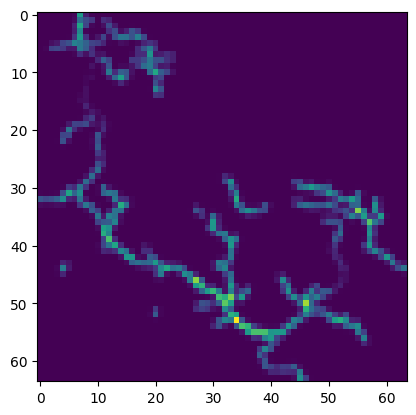

(4096,)
(1366,) (1366,)
39


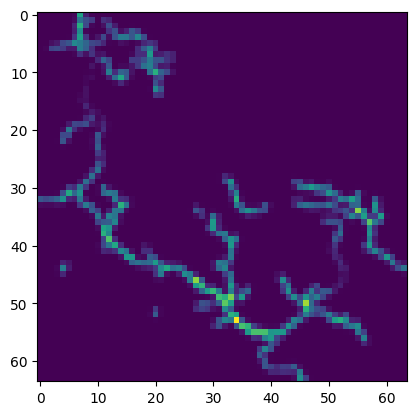

(4096,)
(1366,) (1366,)
40


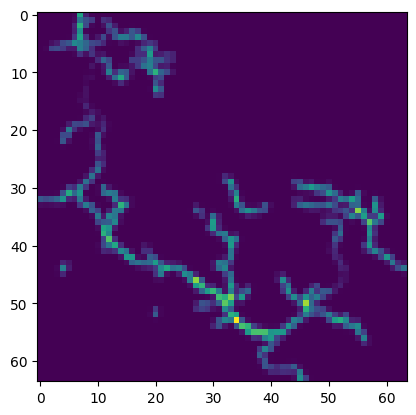

(4096,)
(1366,) (1366,)
41


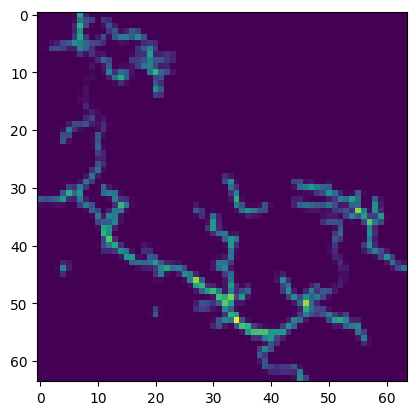

(4096,)
(1366,) (1366,)
42


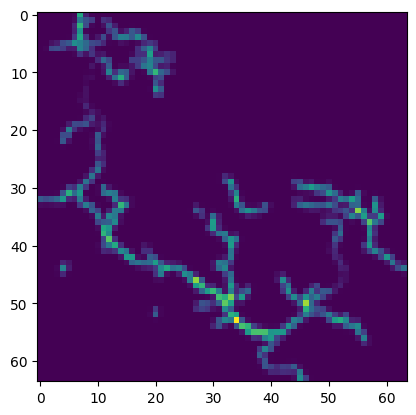

(4096,)
(1366,) (1366,)
43


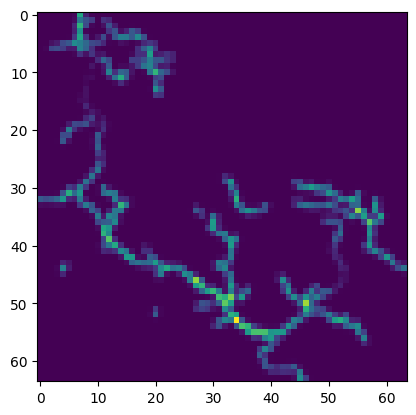

(4096,)
(1366,) (1366,)
44


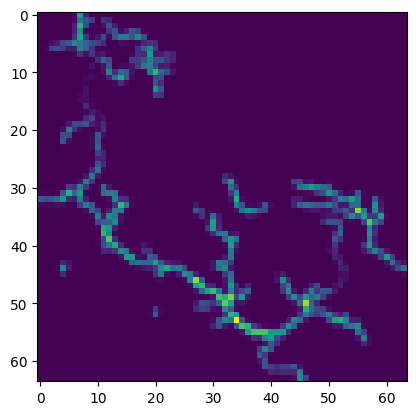

(4096,)
(1366,) (1366,)
45


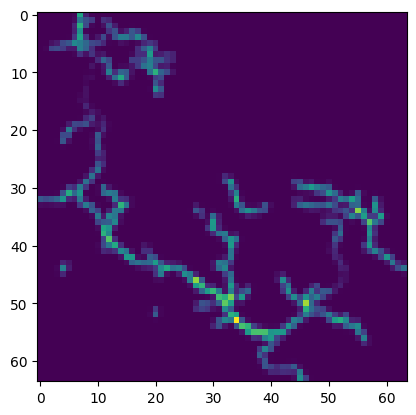

(4096,)
(1366,) (1366,)
46


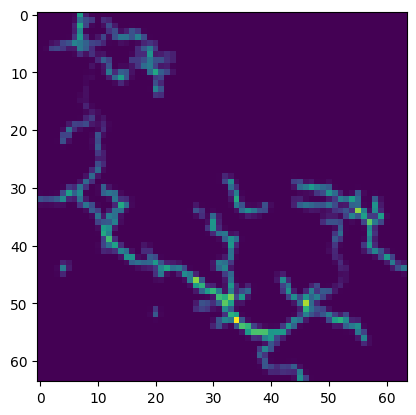

(4096,)
(1366,) (1366,)
47


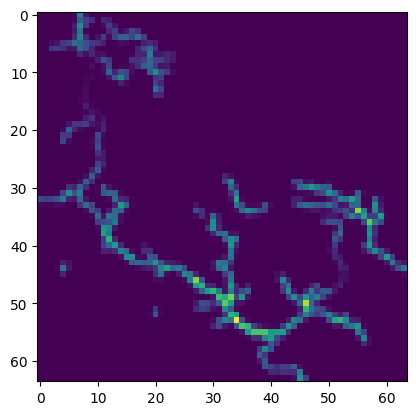

(4096,)
(1366,) (1366,)
48


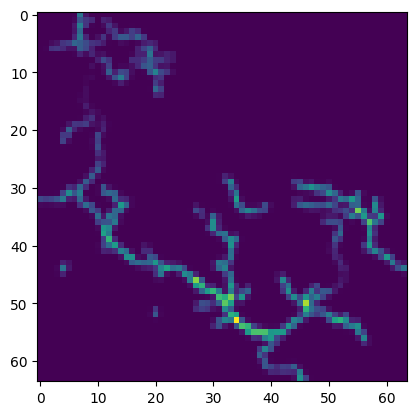

(4096,)
(1366,) (1366,)
49


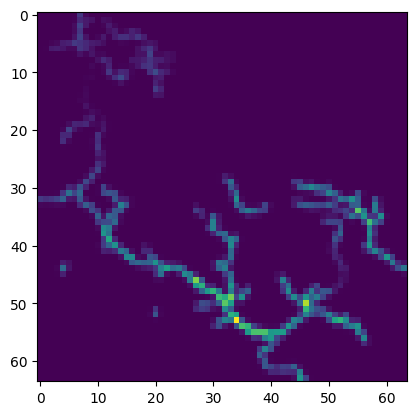

(4096,)
(1366,) (1366,)
50


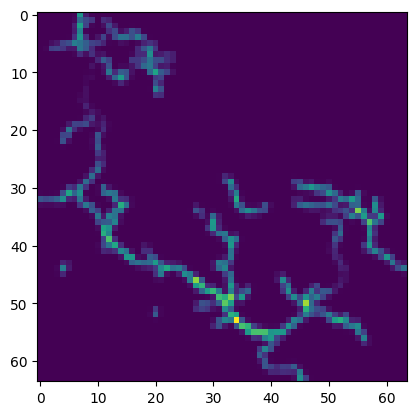

(4096,)
(1366,) (1366,)
51


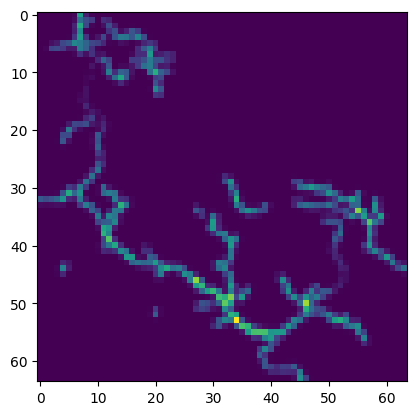

(4096,)
(1366,) (1366,)
52


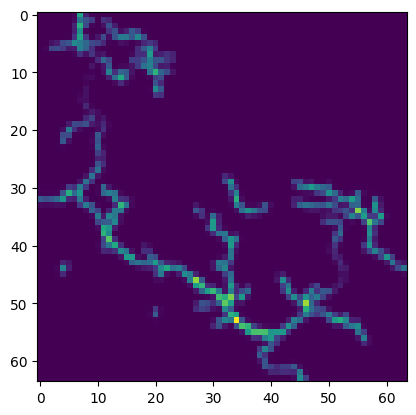

(4096,)
(1366,) (1366,)
53


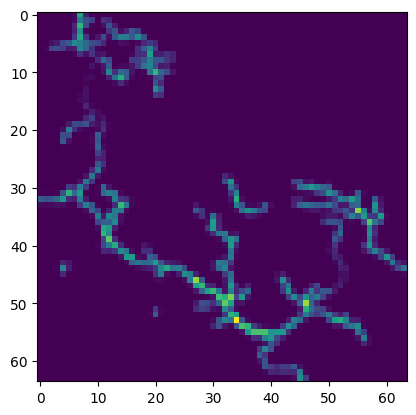

(4096,)
(1366,) (1366,)
54


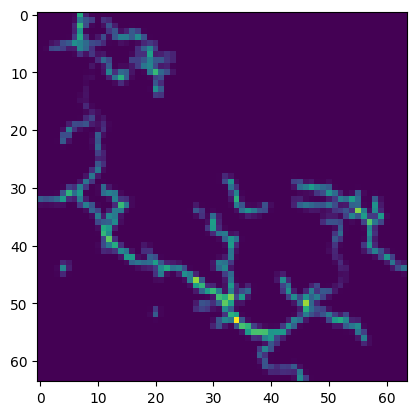

(4096,)
(1366,) (1366,)
55


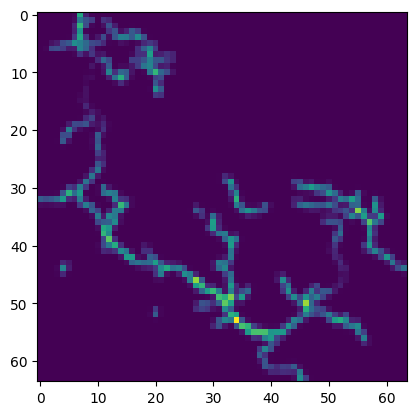

(4096,)
(1366,) (1366,)
56


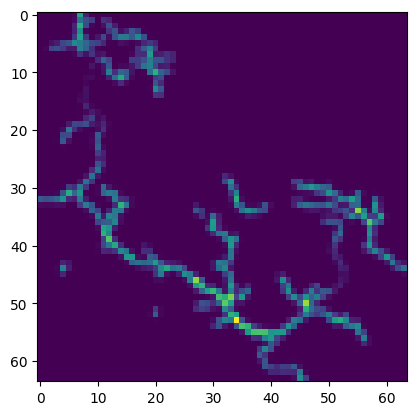

(4096,)
(1366,) (1366,)
57


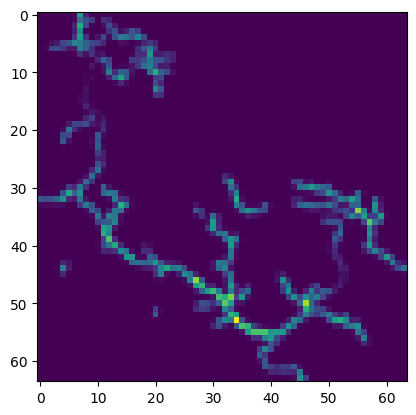

(4096,)
(1366,) (1366,)
58


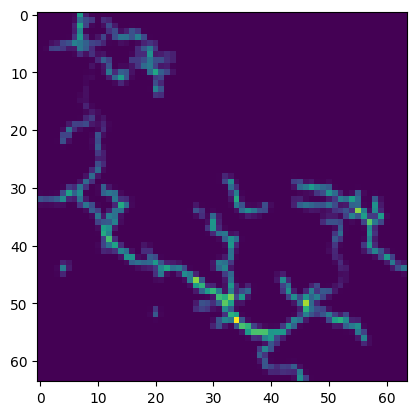

(4096,)
(1366,) (1366,)
59


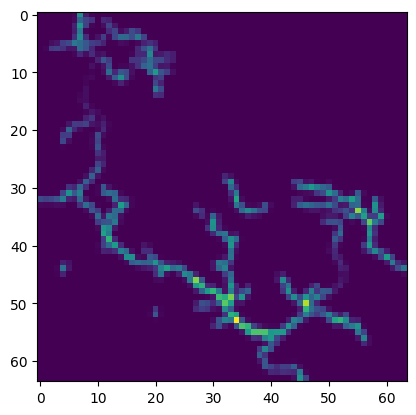

(4096,)
(1366,) (1366,)
60


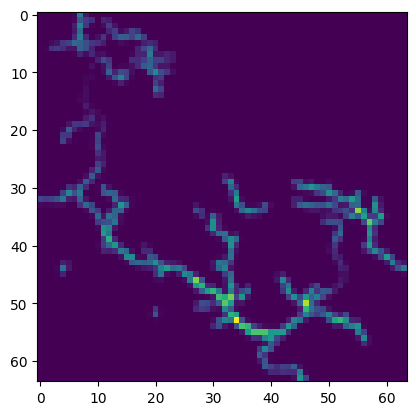

(4096,)
(1366,) (1366,)
61


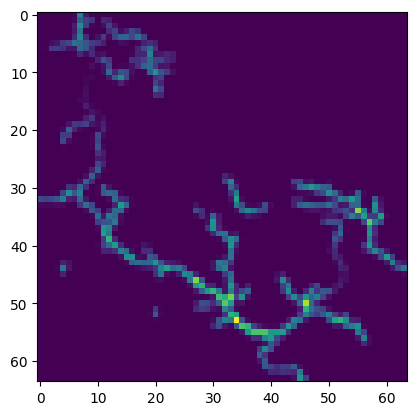

(4096,)
(1366,) (1366,)
62


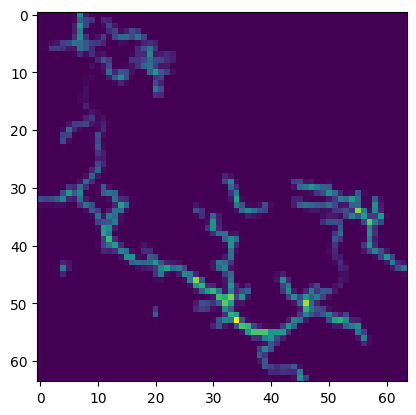

(4096,)
(1366,) (1366,)
63


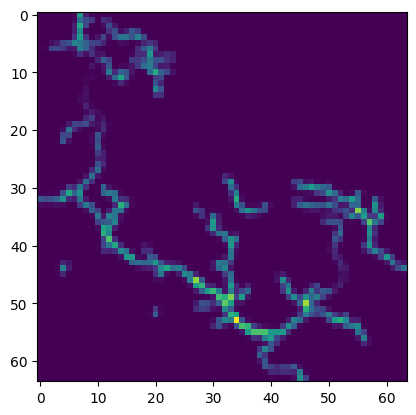

(4096,)
(1366,) (1366,)
64


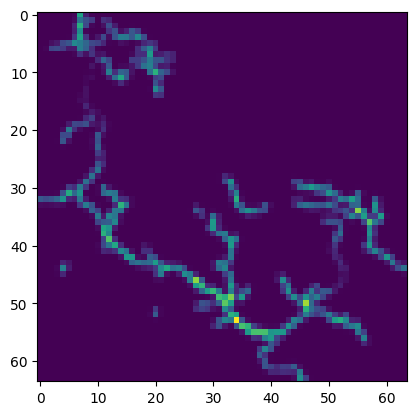

(4096,)
(1366,) (1366,)
65


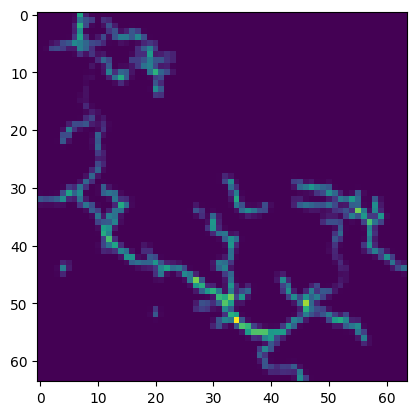

(4096,)
(1366,) (1366,)
66


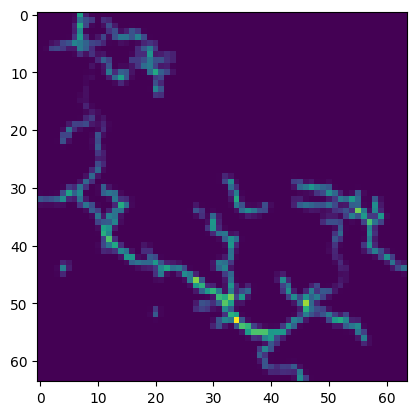

(4096,)
(1366,) (1366,)
67


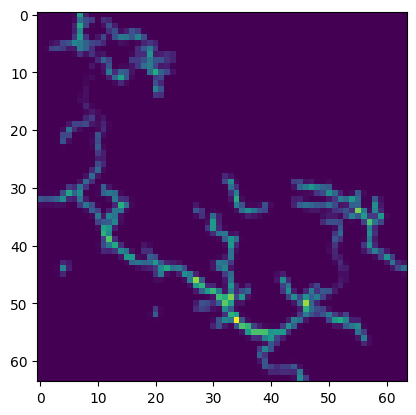

(4096,)
(1366,) (1366,)
68


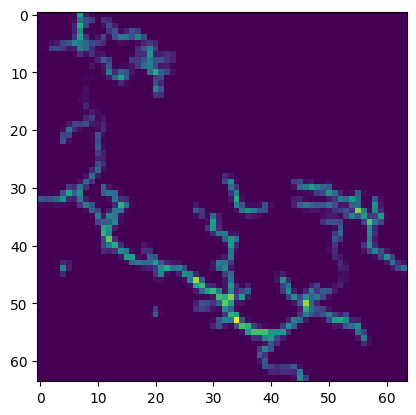

(4096,)
(1366,) (1366,)
69


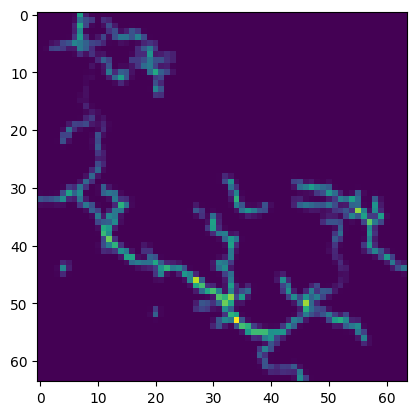

(4096,)
(1366,) (1366,)
70


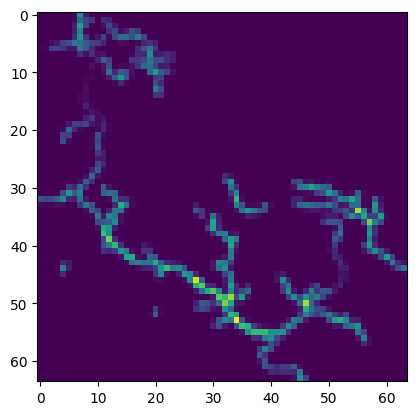

(4096,)
(1366,) (1366,)
71


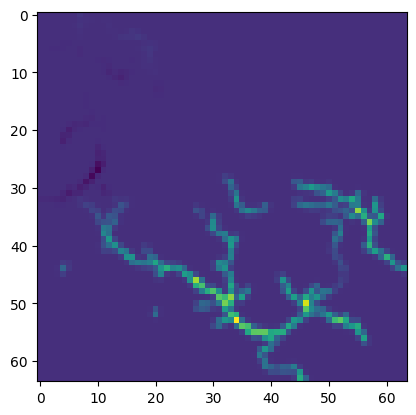

(4096,)
(1366,) (1366,)
72


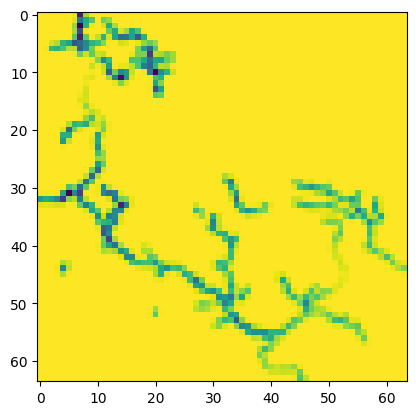

(4096,)
(1366,) (1366,)
73


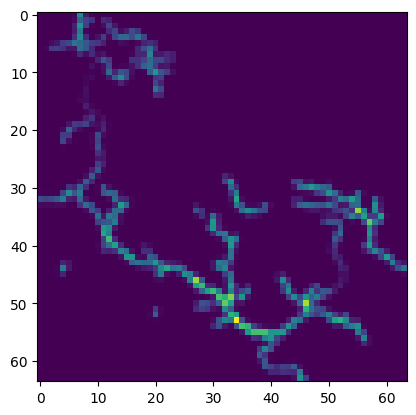

(4096,)
(1366,) (1366,)
74


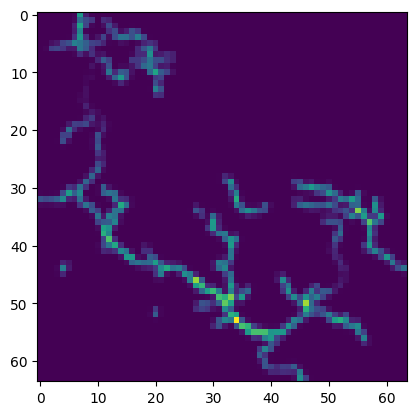

(4096,)
(1366,) (1366,)
75


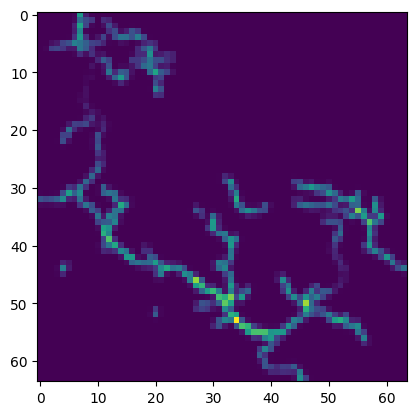

(4096,)
(1366,) (1366,)
76


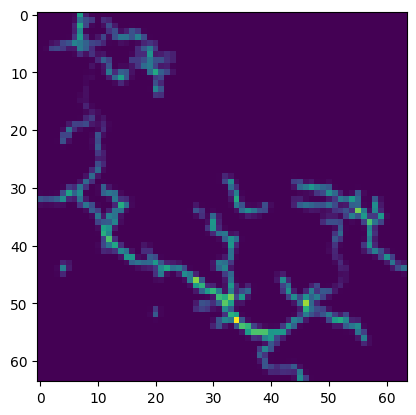

(4096,)
(1366,) (1366,)
77


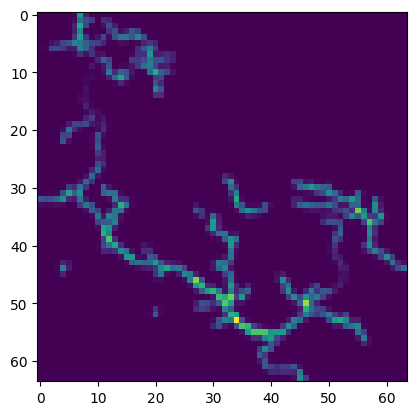

(4096,)
(1366,) (1366,)
78


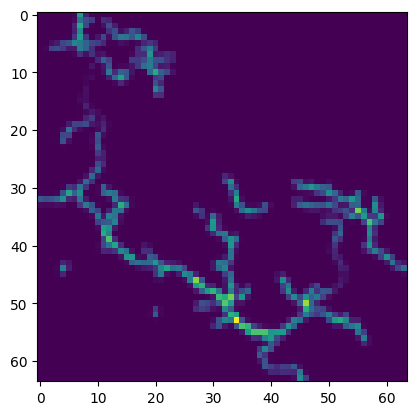

(4096,)
(1366,) (1366,)
79


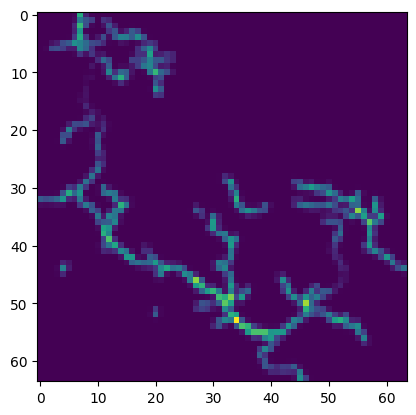

(4096,)
(1366,) (1366,)
80


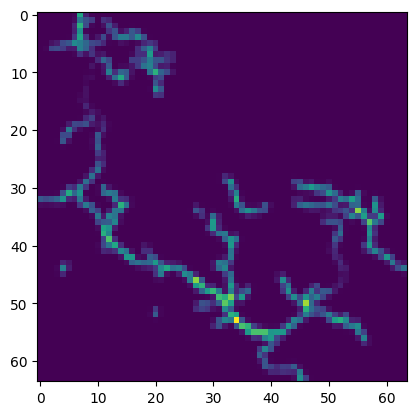

(4096,)
(1366,) (1366,)
81


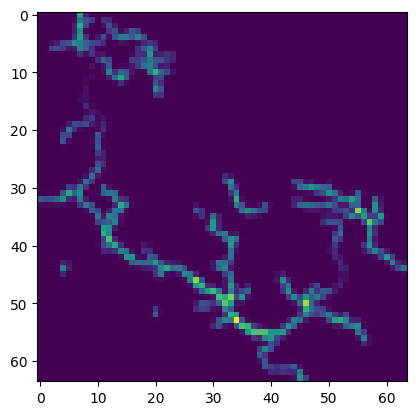

(4096,)
(1366,) (1366,)
82


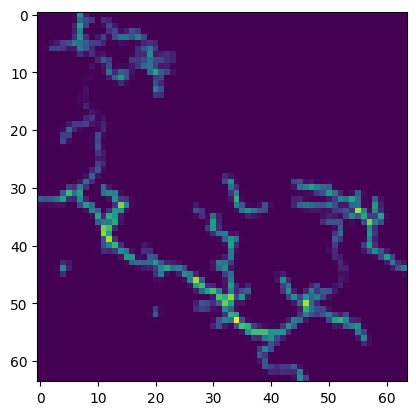

(4096,)
(1366,) (1366,)
83


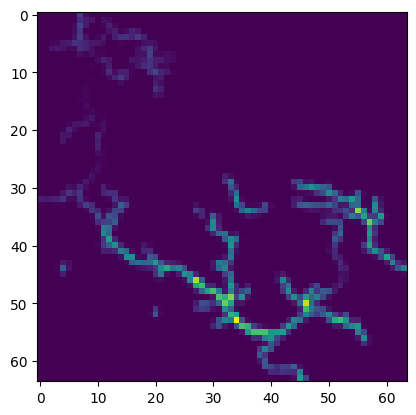

(4096,)
(1366,) (1366,)
84


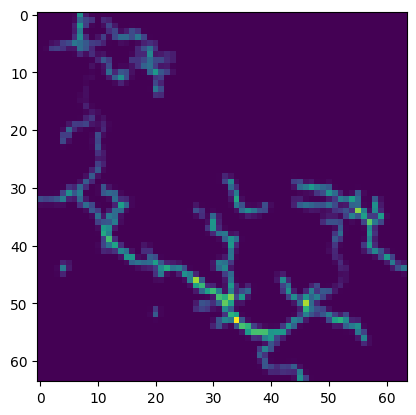

(4096,)
(1366,) (1366,)
85


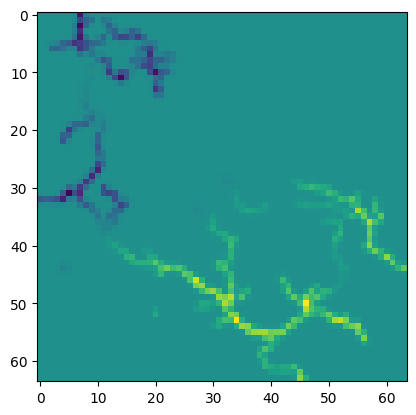

(4096,)
(1366,) (1366,)
86


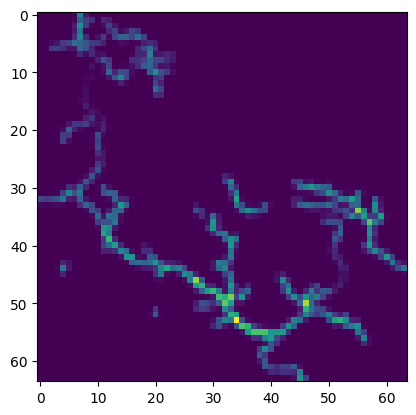

(4096,)
(1366,) (1366,)
87


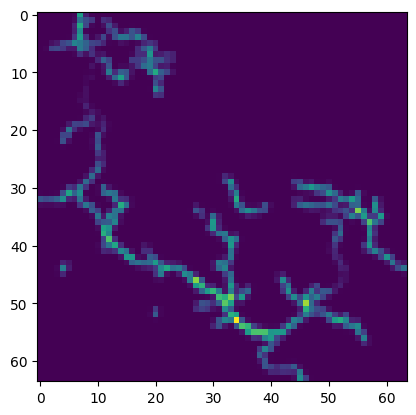

(4096,)
(1366,) (1366,)
88


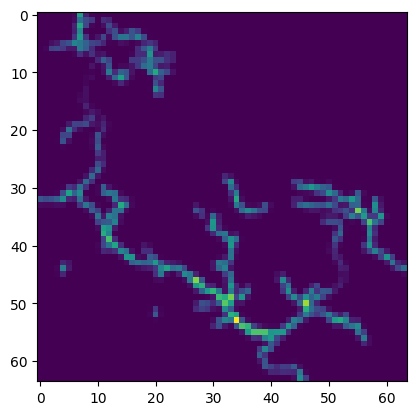

(4096,)
(1366,) (1366,)
89


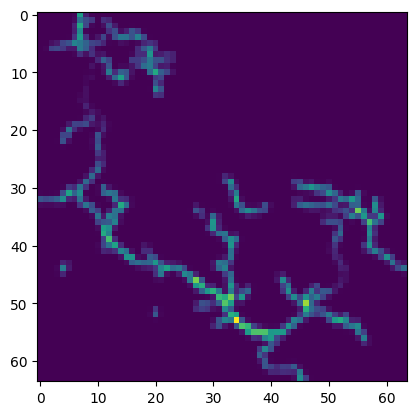

(4096,)
(1366,) (1366,)
90


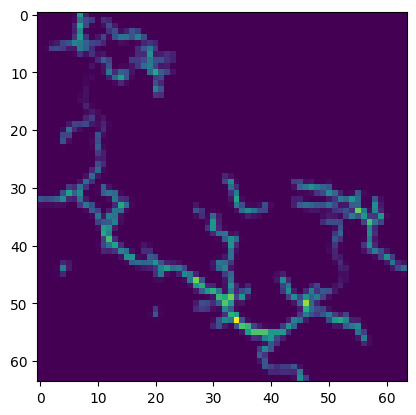

(4096,)
(1366,) (1366,)
91


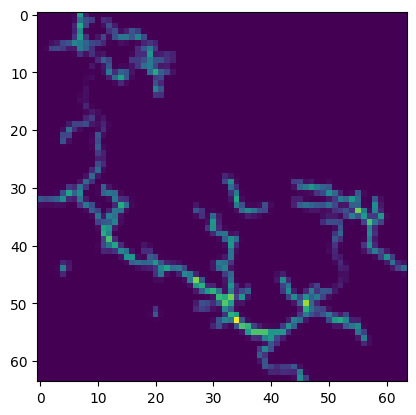

(4096,)
(1366,) (1366,)
92


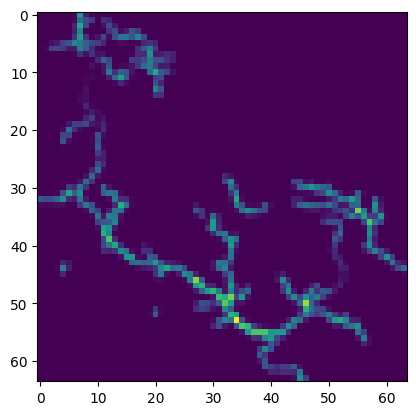

(4096,)
(1366,) (1366,)
93


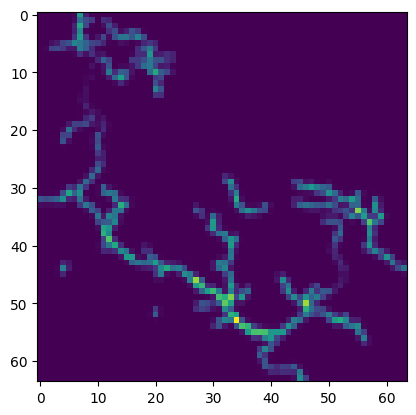

(4096,)
(1366,) (1366,)
94


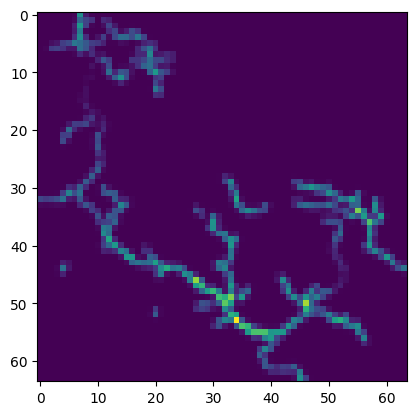

(4096,)
(1366,) (1366,)
95


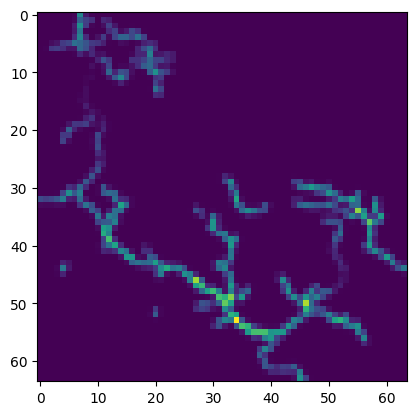

(4096,)
(1366,) (1366,)
96


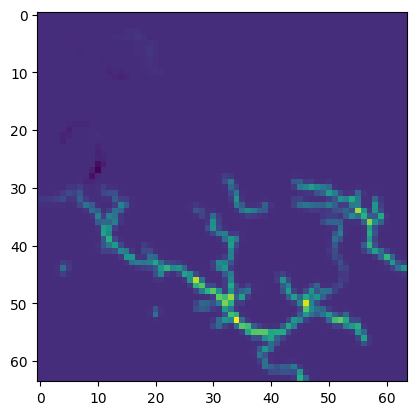

(4096,)
(1366,) (1366,)
97


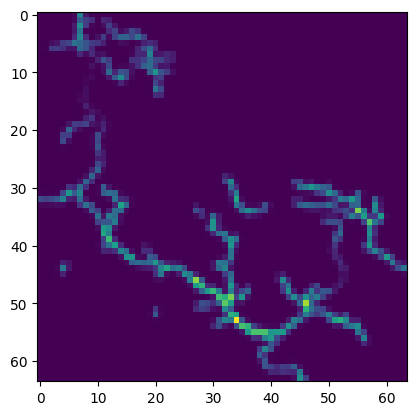

(4096,)
(1366,) (1366,)
98


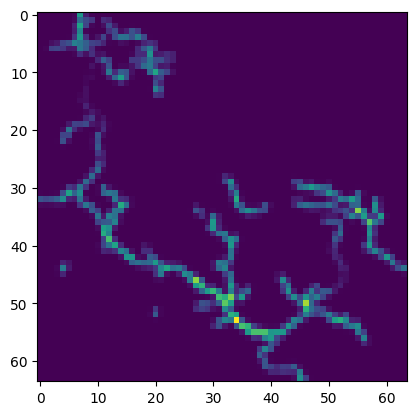

(4096,)
(1366,) (1366,)
99


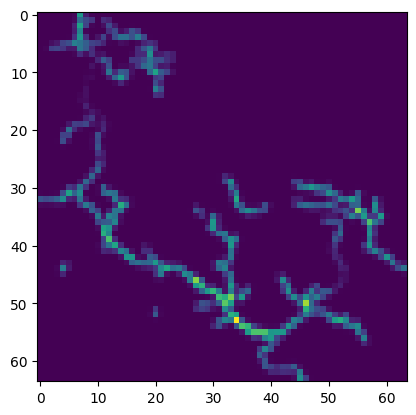

(4096,)
(1366,) (1366,)
100


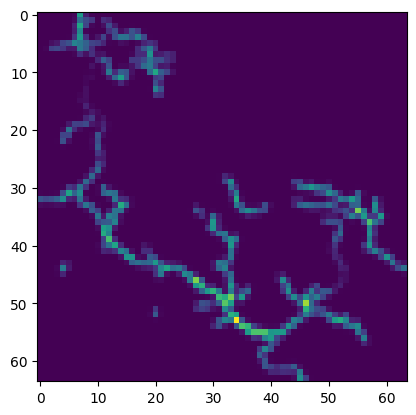

(4096,)
(1366,) (1366,)
101


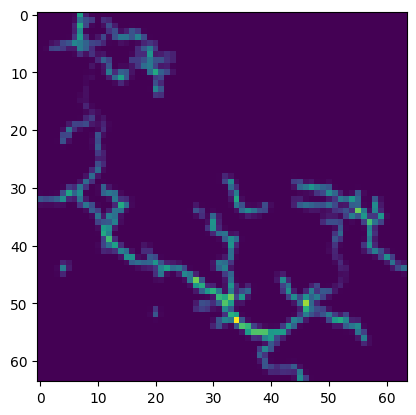

(4096,)
(1366,) (1366,)
102


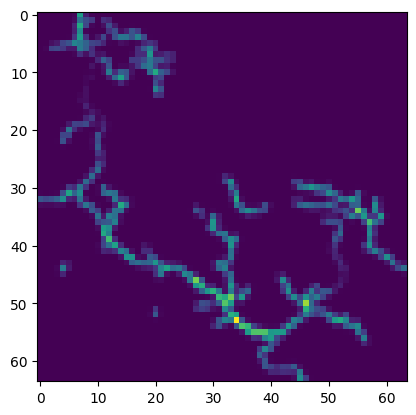

(4096,)
(1366,) (1366,)
103


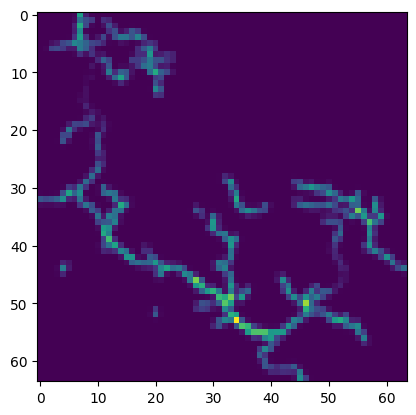

(4096,)
(1366,) (1366,)
104


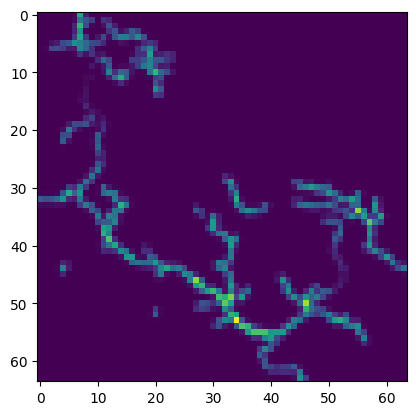

(4096,)
(1366,) (1366,)
105


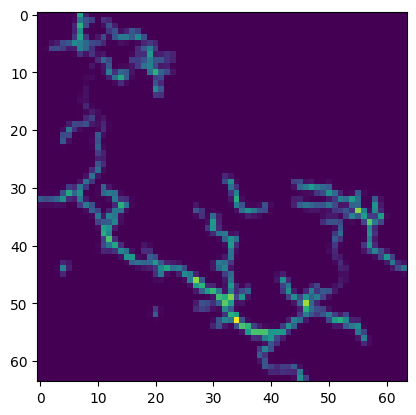

(4096,)
(1366,) (1366,)
106


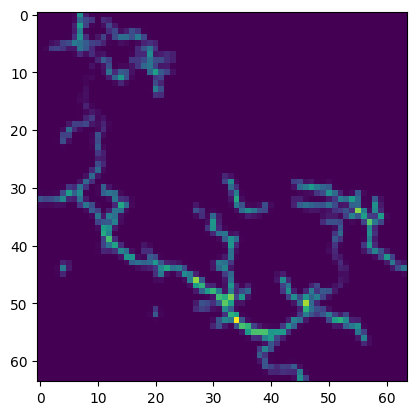

(4096,)
(1366,) (1366,)
107


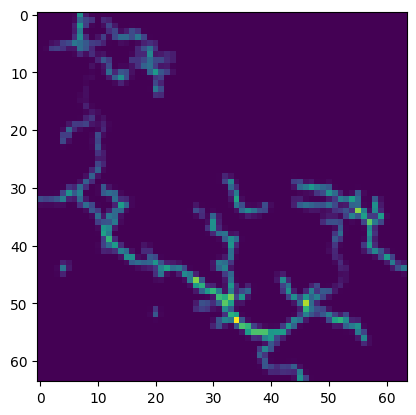

inputs shape: (108, 1366) (108, 1366)


In [ ]:
filt_air_data = []
filt_outputs = []

for i in range(air_data.shape[0]):
  img = air_data[i]
  target = targets_data[i]


  img = img.flatten()
  targ_img = target.flatten()
  print(targ_img.shape)

  img = img[targ_img!=0] # flattening and filtering the image
  targ_img_filt = targ_img[targ_img!=0]
  print(img.shape,targ_img_filt.shape)

  if img.shape == targ_img_filt.shape and not img.shape[0]==0: # only add the image if it contains temperature data for all the river
    print(i)
    plt.imshow(air_data[i])
    plt.show()
    filt_air_data.append(img)
    filt_outputs.append(targ_img_filt)



filt_air_data = np.array(filt_air_data)
filt_outputs = np.array(filt_outputs)
print('inputs shape:',filt_air_data.shape,filt_outputs.shape)

In [ ]:
X = np.column_stack((filt_air_data, filt_air_data**2))  # Two features: T_a and T_a^2

# Split the data into training and test sets
X_train, X_test, T_w_train, T_w_test = train_test_split(X, filt_outputs, test_size=0.2, random_state=42)

In [ ]:
# Create the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, T_w_train)

# Predict water temperature
T_w_pred = model.predict(X_test)

# Print coefficients
print(f"b (coefficient for T_a^2): {model.coef_[1]}")
print(f"c (coefficient for T_a): {model.coef_[0]}")
print(f"d (intercept): {model.intercept_}")


b (coefficient for T_a^2): [-2.00187443e+08 -2.26636443e+08  4.64895423e+07 ...  3.62151160e+07
  2.93694053e+07  1.61654673e+04]
c (coefficient for T_a): [-8.31056890e+02 -9.40857099e+02  1.92996393e+02 ...  1.50343204e+02
  1.21923964e+02  6.71092192e-02]
d (intercept): [1.47655862e+01 3.55677811e+06 5.69837618e+07 ... 3.43591462e+07
 1.54802360e+07 4.38181970e+05]


Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(T_w_test, T_w_pred)
r2 = r2_score(T_w_test, T_w_pred)

print(f'Mean Squared Error: {mse}')
print(f'R²: {r2}')

Mean Squared Error: 1220463423077.2197
R²: -2251418024430.5293


In [ ]:
results = evaluate_model(T_w_test, T_w_pred)
for k,v in results.items():
  print(k,':',v)

MAE : 254138.30354829767
MSE : 0.002523084150256121
RMSE : 1104745.8635709933
R² : -2251418024430.5293
MAPE (%) : 31335903.84703621
MSE sample-wise : 1220463423077.2197


### Save model results

In [ ]:
model_name = "physics_LR"
details = "RGB masked filtered air inputs, val results"
file_path = "/content/gdrive/MyDrive/TFG/results/model_results.xlsx"


# Update Excel with new results
update_excel_with_results(file_path, model_name, results['MSE'], results['MAE'], details)